# Separazione di immagini Cifar10

Il modello prende in input una immagine ottenuta come media di due campioni random presi da Cifar10, e deve predirre le categorie delle due componenti.

La prima immagine appartiene alle prime 5 categorie (airplane, automobile, bird, cat, deer), mentre la seconda appartiene alle restanti (dog, frog, horse, ship, truck). Il modello deve restituire due label, ognuna in un range di 5 valori.

La metrica con cui valutare il modello è la seguente: calcolate l'accuratezza della classificazione per le due immagini componenti, e poi fatene la media.

La metrica deve essere valutata su 10000 input generati da dati di test. Ripetete il calcolo 10 volte e misurate la deviazione standard, che deve essere riportata.

Nel seguito si fornisce un generatore dei dati e qualche esempio.

#Preparazione dei dati

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Load data
(cifar10_x_train_val, cifar10_y_train_val), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()

# Dataset division in train, validation and test
train_size = 40000
val_size = 10000
test_size = 10000

cifar10_x_train, cifar10_x_val = cifar10_x_train_val[:train_size, ...], cifar10_x_train_val[train_size:, ...]
cifar10_y_train, cifar10_y_val = cifar10_y_train_val[:train_size, ...], cifar10_y_train_val[train_size:, ...]

assert cifar10_x_train.shape == (train_size, 32, 32, 3)
assert cifar10_x_val.shape == (val_size, 32, 32, 3)
assert cifar10_x_test.shape == (test_size, 32, 32, 3)
assert cifar10_y_train.shape == (train_size, 1)
assert cifar10_y_val.shape == (val_size, 1)
assert cifar10_y_test.shape == (test_size, 1)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_val = (cifar10_x_val/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

170498071/170498071 [==============================] - 2s 0us/step


Separiamo le immagini in due gruppi, in relazione alla loro etichetta.


In [3]:
# Training set separation by labels
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

# Validation set separation by labels
cond_1_val = cifar10_y_val[:,0] < 5
cifar10_x_val_1 = cifar10_x_val[cond_1_val]
cifar10_y_val_1 = cifar10_y_val[cond_1_val]

cond_2_val = cifar10_y_val[:,0] >= 5
cifar10_x_val_2 = cifar10_x_val[cond_2_val]
cifar10_y_val_2 = cifar10_y_val[cond_2_val]

# Test set separation by labels
cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Adesso possiamo definire il generatore. In input abbiamo due datasets (X1,X2), le etichette corrispondenti (Y1,Y2) e una batchsize.

Il generatore resituisce x_data, y_data, dove

*   x_data è una batch di immagini ottenute come media di campioni random in X1 and X2
*   y_data è una coppia di batch di etichette relative alle immagini componenti, espresse in formato categorico

In [4]:
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = [Y1_cat[num1],Y2_cat[num2]]

    yield x_data, y_data 

Instanziamo un generatore per train set e validation set, con batchize le rispettive sizes.

In [5]:
# Train data generation
train_data = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,train_size)

# Validation data generation
val_data = datagenerator(cifar10_x_val_1,cifar10_x_val_2,cifar10_y_val_1,cifar10_y_val_2,val_size)

Genero e stampo diversi esempi

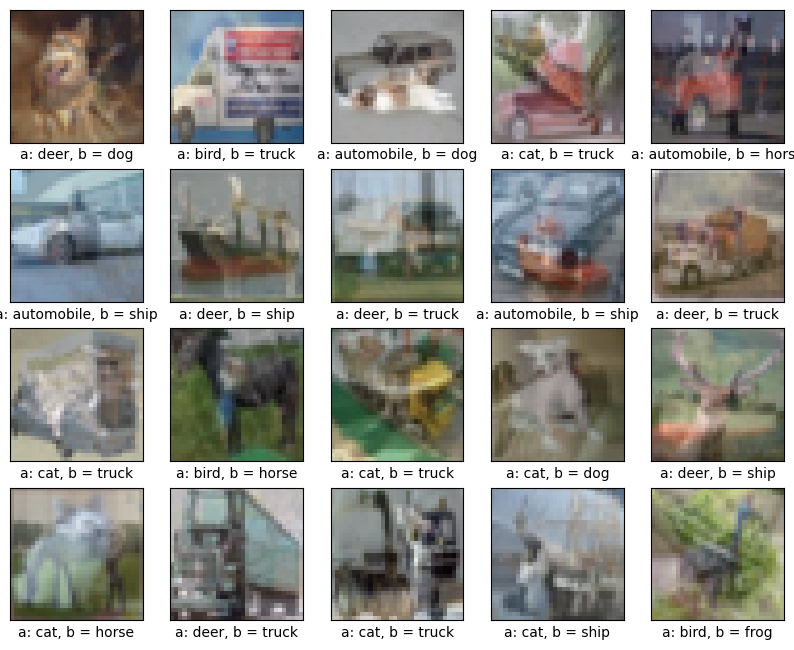

In [6]:
# Train data examples plot
x_train_data, y_train_data = next(train_data)
x_val_data, y_val_data = next(val_data)

plt.figure(figsize=(10,10))

for i in range(20):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train_data[i])

  plt.xlabel("a: {}, b = {}".format(classes[np.argmax(y_train_data[0][i])],classes[np.argmax(y_train_data[1][i])+5]))

  plt.show

In [7]:
# y to array
y_train_data = np.array(y_train_data)
y_val_data = np.array(y_val_data)

# y division in the 2 groups of classes
y_train_data_0 = y_train_data[0,:]
y_train_data_1 = y_train_data[1,:] 
y_val_data_0 = y_val_data[0,:]
y_val_data_1 = y_val_data[1,:]

#Allenamento della rete

In [8]:
# Final metrics definition (accuracy averages)
class MergeMetrics(tf.keras.callbacks.Callback):

    def __init__(self,**kargs):
        super(MergeMetrics,self).__init__(**kargs)

    def on_epoch_begin(self,epoch, logs={}):
        return

    # Average accuracy on train and validation
    def on_epoch_end(self, epoch, logs={}):
        logs['avg_acc'] = np.mean((logs["output1_accuracy"], logs["output2_accuracy"]))
        logs['val_avg_acc'] = np.mean((logs["val_output1_accuracy"], logs["val_output2_accuracy"]))

    # Average accuracy on test
    def on_test_end(self, logs={}):
        logs['avg_acc'] = np.mean((logs["output1_accuracy"], logs["output2_accuracy"]))

In [9]:
input_shape = (32, 32, 3)  # CIFAR-10 images dimensions

# Convolutional block
inputs = tf.keras.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs) # Conv layer
x = layers.BatchNormalization()(x) # batch normalization to reduce overfitting
x = layers.MaxPooling2D(pool_size=(2, 2))(x) # max pooling
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.5)(x) # dropout layer to reduce overfitting
x = layers.Flatten()(x) # tensor flattening

# Dense block -> output split
# Output for the first image
dense1 = layers.Dense(64, activation='selu')(x)
dense1 = layers.Dropout(0.25)(dense1)
output1 = layers.Dense(5, activation='softmax', name='output1')(dense1)

# Output for the second image
dense2 = layers.Dense(64, activation='selu')(x)
dense2 = layers.Dropout(0.25)(dense2)
output2 = layers.Dense(5, activation='softmax', name='output2')(dense2)

# Model definition
model = tf.keras.Model(inputs=inputs, outputs=[output1, output2])

# Model compile
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) # learning rate lowering
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation - overfitting reduction
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

# Checkpoint for merged metrics callbacks
checkpoint = MergeMetrics()

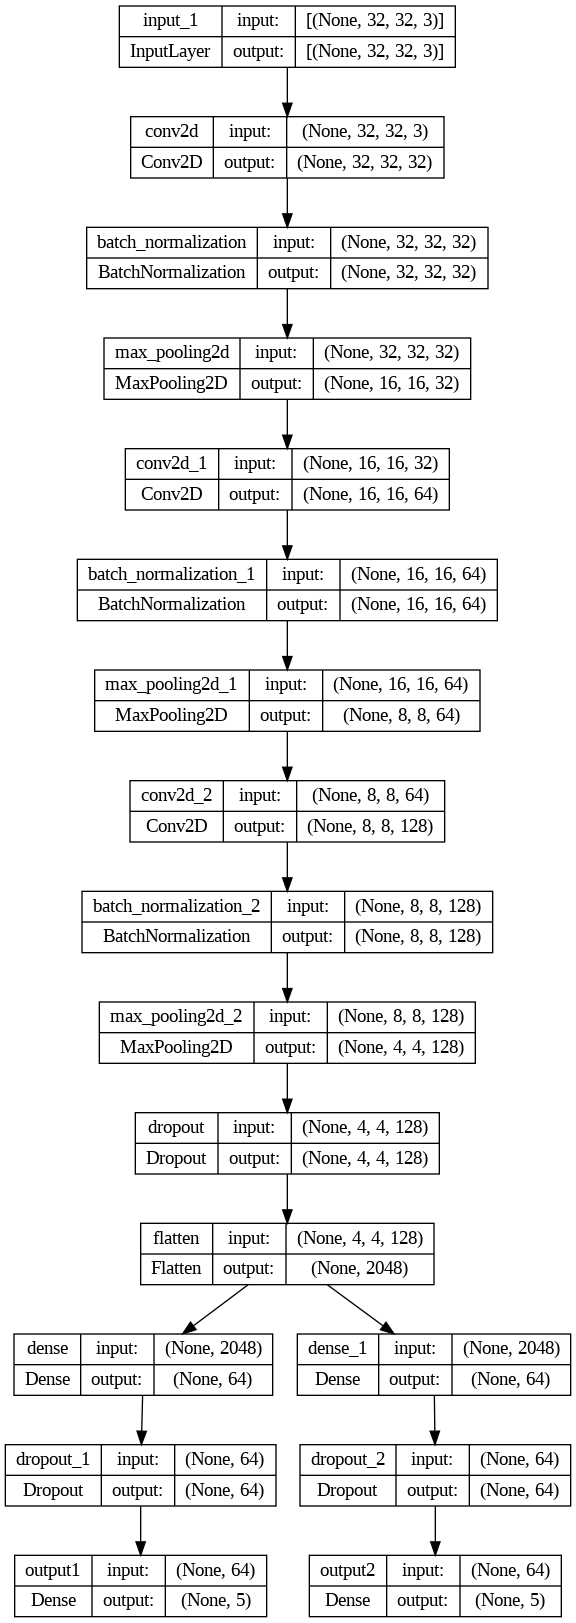

In [10]:
# Model plot
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
# Model training with data augmentation
training = model.fit(data_augmentation(x_train_data), [y_train_data_0, y_train_data_1], epochs=50, callbacks=[checkpoint], batch_size=128, validation_data=(x_val_data, [y_val_data_0, y_val_data_1]))

Epoch 1/50
313/313 [==============================] - 21s 17ms/step - loss: 5.7529 - output1_loss: 2.8173 - output2_loss: 2.9356 - output1_accuracy: 0.2698 - output2_accuracy: 0.2793 - val_loss: 5.6367 - val_output1_loss: 2.3539 - val_output2_loss: 3.2828 - val_output1_accuracy: 0.2759 - val_output2_accuracy: 0.2046 - avg_acc: 0.2746 - val_avg_acc: 0.2403
Epoch 2/50
313/313 [==============================] - 4s 12ms/step - loss: 4.3536 - output1_loss: 2.1659 - output2_loss: 2.1877 - output1_accuracy: 0.3027 - output2_accuracy: 0.3225 - val_loss: 2.9445 - val_output1_loss: 1.4827 - val_output2_loss: 1.4618 - val_output1_accuracy: 0.3864 - val_output2_accuracy: 0.4333 - avg_acc: 0.3126 - val_avg_acc: 0.4099
Epoch 3/50
313/313 [==============================] - 4s 12ms/step - loss: 4.0714 - output1_loss: 2.0434 - output2_loss: 2.0279 - output1_accuracy: 0.3159 - output2_accuracy: 0.3390 - val_loss: 2.9691 - val_output1_loss: 1.4638 - val_output2_loss: 1.5054 - val_output1_accuracy: 0.3672

# Verifica dell'accuratezza della rete

<Axes: >

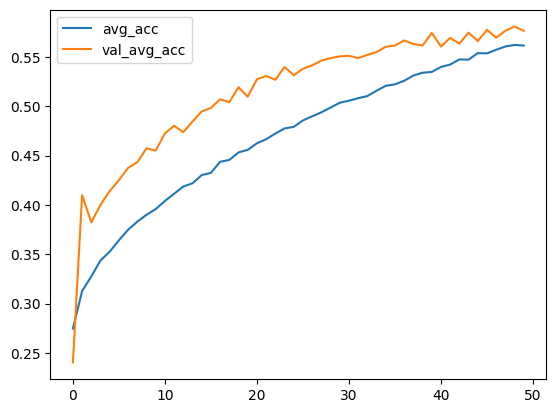

In [13]:
pd.DataFrame(training.history)[["avg_acc", "val_avg_acc"]].plot() # average accuracy vs validation average accuracy

In [12]:
evals = [] # Accuracies vector initialization

for i in range (10):
  print(i+1, ': ')
  # Test data generation (a new test set is generated every iteration)
  test_data = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,test_size) 
  x_test_data, y_test_data = next(test_data)

  # y to array
  y_test_data = np.array(y_test_data)

  # y division for the 2 groups of classes
  y_test_data_0 = y_test_data[0,:]
  y_test_data_1 = y_test_data[1,:]

  # Model evaluation
  e = model.evaluate(x_test_data, [y_test_data_0, y_test_data_1], callbacks=[checkpoint])
  evals.append(e[4])

# Standard Deviation
std_dev = np.std(evals)
print('Standard Deviation: ', std_dev)


1 : 
313/313 [==============================] - 1s 4ms/step - loss: 2.1457 - output1_loss: 1.1273 - output2_loss: 1.0184 - output1_accuracy: 0.5425 - output2_accuracy: 0.6038 - avg_acc: 0.5732
2 : 
313/313 [==============================] - 1s 4ms/step - loss: 2.1484 - output1_loss: 1.1330 - output2_loss: 1.0154 - output1_accuracy: 0.5377 - output2_accuracy: 0.6107 - avg_acc: 0.5742
3 : 
313/313 [==============================] - 1s 4ms/step - loss: 2.1511 - output1_loss: 1.1292 - output2_loss: 1.0219 - output1_accuracy: 0.5362 - output2_accuracy: 0.6047 - avg_acc: 0.5705
4 : 
313/313 [==============================] - 1s 4ms/step - loss: 2.1288 - output1_loss: 1.1224 - output2_loss: 1.0063 - output1_accuracy: 0.5461 - output2_accuracy: 0.6104 - avg_acc: 0.5783
5 : 
313/313 [==============================] - 1s 4ms/step - loss: 2.1394 - output1_loss: 1.1234 - output2_loss: 1.0160 - output1_accuracy: 0.5486 - output2_accuracy: 0.6080 - avg_acc: 0.5783
6 : 
313/313 [=====================